# Text Analysis on customer support tweets

With the increase in the popularity of social media and the increased number of users, Social media monitoring has become a very important aspect to companies that aim at maintaining good customer relations.

Social media monitoring helps companies not only to interact with customers easily but also they can find the issues or the primary concerns faced by the customers.

The main aim of this project is to identify the patterns in the twitter conversations between various companies and their customers in order to identify the primary concerns of the consumers

Please find the data set that has been taken from kaggle. https://www.kaggle.com/thoughtvector/customer-support-on-twitter

This is an unsupervised learning model and Topic modelling techniques (primarily LDA) have been used for the model creation. The hence created model is verified by using the two parameters perplexity score and coherence score.

<h4> Describing the Dataset</h4>

The dataset contains seven columns, each described as below:
<p>
    1. <b>Tweet_id:</b> Unique identification number to identify each tweet<br>
    2. <b>Author_id:</b> Unique identification number to identify the user (the one who is tweeting). Numbers have beenused for IDs of customers to maintain privacy<br>
    3. <b>Inbound:</b> The value of Inbound is "True" if the tweet is tweeted by a user but not the company. Inbound value is "False", if the tweet is tweeted by the Company.<br>
    4. <b>CreatedDate:</b> Timestamp of the tweet.<br>
    5. <b>Text:</b> Text data of the tweet<br>
    6. <b>Response_tweet_id:</b> Provides the list of tweet_ids responded to the particular tweet.<br>
    7. <b>In_response_to_tweet_id:</b> Provides the tweet_id to which the particular tweet is responding to (in response to which tweet id)<br>
</p>

<h4> Major Constraints in processing </h4>

The enormous amount of data present (more than 30 million records) in the data set has been consuming a lot of time to process the machine learning algorithms and also the preprocessing has been taking lot of time and hence only the top 25 companies were selected, but even the top 25 companies were consuimg lot of time for training and preprocessing.Hence we only picked the companies ranking from 21 to 25 in terms of number of tweets. This particular set of companies were selected because they have optimum number of records for preprocessing and training. However the data visualization was done on top 25 comapnies, pre processing and training are done the companies ranked from 21 to 25<br>
<p><b>Note :</b> All the references are given in the end of the notebook </p>


In [1]:
#Importing the required libraries
import pandas as pd   #pandas library
import numpy as np    #numpy library
import nltk           #NLTK library
from nltk.tokenize import word_tokenize   #nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from collections import Counter
from nltk.util import ngrams
from collections import Counter
import os
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import random
#impporting required gensim packages
import gensim
import gensim.corpora as corpora
import gensim.models as models
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import CoherenceModel
from pprint import pprint


#packages required for visualization
import pyLDAvis
import pyLDAvis.gensim
import pickle 

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mahil\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


The data set was available on kaggle as single large csv file. This file has been split into six files inorder to enhance the processing speed for adding the 'sentTo' coloumn in the data set for recognizing the recipient of the tweet. 

base logic for adding sentTo :

Tracing the in_response_to_tweet_id to identify whom the tweet is intended to

data["in_response_to_tweet_id"]=pd.to_numeric(data['in_response_to_tweet_id'],errors='coerce')
df_=data[["tweet_id","author_id"]]
df_=df_.rename(columns={"tweet_id":"in_response_to_tweet_id","author_id":"Sent_to"})
data=pd.merge(data,df_,on=["in_response_to_tweet_id"],how="left")

Returns the data into 6 csv with one more included column "sentTo"

In [2]:
# Importing all the data that has been split into 6 files
a = pd.read_csv('a.csv')
b = pd.read_csv('b.csv')
c = pd.read_csv('c.csv')
d = pd.read_csv('d.csv')
e = pd.read_csv('e.csv')
f = pd.read_csv('f.csv')
#removing the first coloumn since that coloumnis just an index
a = a.iloc[:,1:]
b = b.iloc[:,1:]
c = c.iloc[:,1:]
d = d.iloc[:,1:]
e = e.iloc[:,1:]
f = f.iloc[:,1:]
#concatinating data from all the data frames into a single data frame
data1 = pd.concat([a, b, c, d, e, f], ignore_index=True)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\mahil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\mahil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\mahil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,5,6,8) have mixed types.Specify

Here we are trying to pick and analyze only the data ony for the top 25 companies with the highest number of tweets because the full data set has a total of 30 million plus records which would take a lot of processing time.

In [3]:
#Calculating the total number of tweets for each company 

#inbound are the tweets which the company has received from the customers
inboundDf = pd.DataFrame(data1["author_id"].value_counts())
#outbound are the tweets which the company has sent as a response to the customer's tweets
outboundDf = pd.DataFrame(data1["sentTo"].value_counts())

#outbound tweets have '@' before the username in the 'sentTo' coloumn and hence removing them  
temp1=outboundDf.index
temp2=[]
for i in temp1:
    temp3=re.sub('@','',i)
    temp2.append(temp3)

###picking only the top hundred records from the inbound Df since we need to pick the top25 companies for our analysis,
###when we add the tweets of both inbound and outbound data, it is very likely that the top companies stay with in the
###first 100
inboundDf=inboundDf.iloc[:100,]
inboundDf.columns = ['count']
inboundDf['name'] = inboundDf.index

###picking only the top hundred records from the outbound Df since we need to pick the top25 companies for our analysis,
###when we add the tweets of both inbound and outbound data, it is very likely that the top companies stay with in the
###first 100
outboundDf.index=temp2
outboundDf=outboundDf.iloc[:100,]
outboundDf.columns = ['count']
outboundDf['name'] = outboundDf.index
outboundDf

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count,name
AmazonHelp,126059,AmazonHelp
AppleSupport,83769,AppleSupport
AmericanAir,42652,AmericanAir
Uber_Support,40990,Uber_Support
Delta,35932,Delta
...,...,...
116072,1902,116072
sizehelpteam,1889,sizehelpteam
116331,1854,116331
115937,1821,115937


Though we have picked top 25 companies for analyzing and visualizing the data, we are going with only 5 companies ranking from 21 to 25 for the preprocessing and model creation. 
This is because, top 25 companies have a total of almost 1.6 million tweets and we tried to train the model , it was taking lot of hours to process, hence we chose to go with the companies ranking from 21 to 25 and the total number of records that we will be processing is aroung 160,000

In [4]:
##After collecting the sum of first 100 records from inbound and outbound dataframes, we need to sum the number of tweets
##in order to get the total no.of tweets that are related to a particular company
df = pd.concat([inboundDf, outboundDf])\
       .groupby('name')['count']\
       .sum().reset_index()
df.sort_values(by=['count'], inplace=True, ascending= False)

##Collecting only the tweets related to a company and removing all the numeric usernames as numeric 
##usernames belong to the customers or individual users
temp1 = pd.Series(df['name'])
temp2 = temp1.str.isnumeric()
df = df.assign(isnumeric = temp2)
index = df.index[df['isnumeric'] == False].tolist()
companies = df.loc[index,:]
del companies['isnumeric']
top25_df = companies.head(25)
companyDf = top25_df.tail(5)
companyDf #this data frame has the list of the last 5 from the top 25 companies along with the total no.of tweets.

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,count
116,VerizonSupport,34581
133,sprintcare,34081
97,O2,32856
104,Safaricom_Care,31567
128,idea_cares,29936


<b>Data Visualization of the numnber of tweets per each company in top 25 list of companies </b>

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-4469c893b6e5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top25_df.sort_values('count',inplace=True)


<AxesSubplot:title={'center':'Total No.of Tweets'}, xlabel='Count', ylabel='Comapany names'>

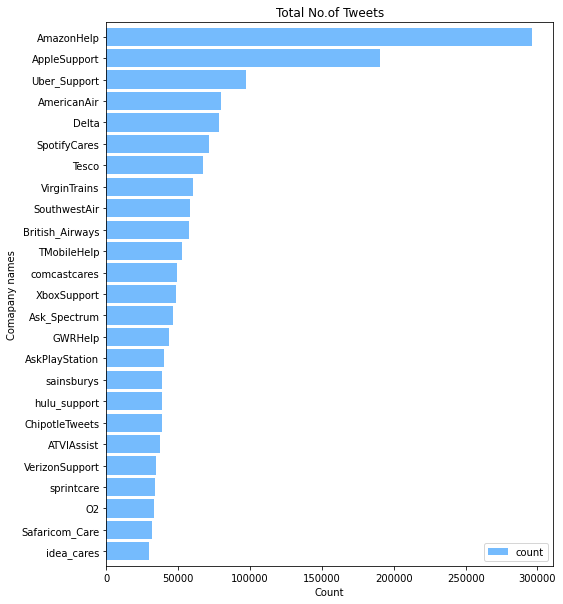

In [5]:
#plotting the total no.of tweets for each company
b=[]
for i in range(len(top25_df)):
    a="#{:06x}".format(random.randint(0, 0x00FFFF))
    b.append(a)
top25_df.sort_values('count',inplace=True)
ax = top25_df.plot(kind='barh', figsize=(8, 10), color='xkcd:sky blue', zorder=2, width=0.85)
ax.set_title('Total No.of Tweets')
ax.set_xlabel('Count')
ax.set_ylabel('Comapany names')
ax.set_yticklabels(top25_df['name'])
ax

<b>Data Visualization of the number conversations that were started with a company support team</b>

In [6]:
# Pick only inbound tweets that aren't in reply to anything and hence fetching the beginning of a conversation
first_inbound = data1[pd.isnull(data1.in_response_to_tweet_id) & data1.inbound]
# We fetch the companies that had the highest number of conversations and not the total no.of tweets
conv = pd.DataFrame(first_inbound["sentTo"].value_counts())
conversations = conv.head(25)
conversations

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentTo
@AppleSupport,42578
@115858,28296
@AmericanAir,21511
@Delta,19109
@AmazonHelp,17222
@SouthwestAir,16724
@Uber_Support,16299
@115873,14877
@British_Airways,14374
@115821,14301


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-7-5a5860f1b8d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversations.sort_values('sentTo',inplace=True)


<AxesSubplot:title={'center':'Total No.of Conversations'}, xlabel='Count', ylabel='Comapany names'>

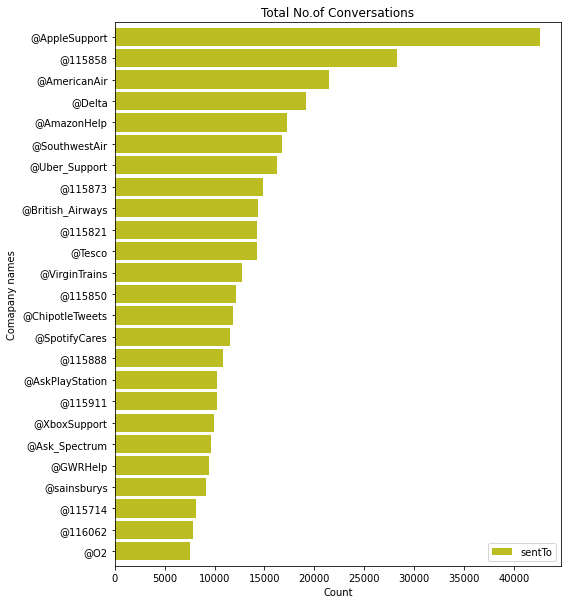

In [7]:
#plotting the no.of conversations
q=[]
for i in range(len(conversations)):
    p="#{:06x}".format(random.randint(0, 0x00FFFF))
    q.append(p)
conversations.sort_values('sentTo',inplace=True)
bx = conversations.plot(kind='barh', figsize=(8, 10), color='tab:olive', zorder=2, width=0.85)
bx.set_title('Total No.of Conversations')
bx.set_xlabel('Count')
bx.set_ylabel('Comapany names')
bx

<b> Interestingly , there are 9 users who are there in the top 25 list of accounts that got hightest number of conversation starter messages, that means it is worth taking a look at the users accounts for any valuable insights</b>

In [8]:
## from the entire data frame 'data1', fetching the data only related to the top 25 companies 
indexI = list(companyDf['name'])
tail5_temp = []
for index in indexI:
    x = (index, str("@" +index))
    tail5_temp.append(x)

df1 = pd.DataFrame()
for x,y in tail5_temp:
    data_comp = pd.concat([data1.loc[data1['author_id'] == x], data1.loc[data1['sentTo'] == y] ])
    df1 = df1.append(data_comp)
data = df1

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data Preprocessing

Preprocessing techniques that have been used :
<p>
    <b>Removal of punctuations:</b> this includes removing all the punctuations, numbers and all the non english charcacters


In [9]:
## Removal of Punctuations
def preprocessing(tweet):
        #Lower casing
        tweet=tweet.lower()
        #removal of punctuations
        tweet=re.sub(r'<.*? >', '', tweet)
        tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",tweet)
        tweet=re.sub(r'[0-9]+', '', tweet)
        return tweet

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:7: DeprecationWarning: invalid escape sequence \w
<>:7: DeprecationWarning: invalid escape sequence \w
<ipython-input-9-bd8b924fae8d>:7: DeprecationWarning: invalid escape sequence \w
  tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",tweet)


<b>Removal of stopwords:</b> A miscelleneous list of stop words have been aquired from the web and have been added along with the stopwords from various libraries like nltk,spacy.
    

In [10]:
#Removal of Stop Words

#A list of Miscelleneous stop words have been picked from ref: ""
misc_stop = pd.read_csv('Misc_Stop_Words.csv')

#spacy stopwords
nlp = English()
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
sw_spacy = list(sw_spacy)
stop_words = nltk.corpus.stopwords.words('english')

# As we are looking at informal text we need to account for abbreviations, acronyms and uncommon words, and include these in our stopword list.
#To do this, we take the difference between the chat words corpus and the words corpus from the nltk library. 
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha()) #checks if all characters in words in text is alphabetic.
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)
unusual_words(nltk.corpus.nps_chat.words())

# Combining the stop words from multiple libraries 
stopwords = stop_words + unusual_words(nltk.corpus.nps_chat.words()) + list(sklearn_stop_words) + list(misc_stop)
stop_words = set(stopwords)
# function to remove stop words
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<b>POS Tagging and Lemmatization</b>: POS tagging has been done before the lemmatization in order to ensure that the words are transformed to their correct
form

In [11]:
# POS Tagging and Lemmatization
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<b>Removal of short words</b>: Short words of character length 1 and 2 have been removed. Since this is social media text processing lot of unwanted short words would be present in the data which adds a lot of noise to the data

In [12]:
#Removal of short words which are of length 1 and 2 character
shortword = re.compile(r'\W*\b\w{1,2}\b')
#function to remove short words
def re_remove(text): return shortword.sub('', text)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<b>Removal of emojis</b>: Emojis have been removed to reduce the noise in the data

In [13]:
#Function to remove the emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<b>Removal of URLs</b>: All the URLs have been removed since in the context of this project which is finding the patterns in the text to identify the consumer issues, URLs doesnot play any role

In [14]:
#function to remove URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<b>Bi Gram models:</b> for creating N grams, bi-grams have been chosen in order to capture few key words in companies like 'fire stick' for amazon.

In [15]:
#Function to create Bi-Grams
def genBigram(tokens):
    bigrams = [" ".join(x) for x in list(ngrams(tokens, 2))]
    return bigrams

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
#function to find the most dominant topic for each document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Removal of punctuations and other unnecessary characters
def textPreProcessingPipeline(data):
    def remove_freqwords(data):
        return " ".join([word for word in str(data).split() if word not in freq_words])
    def remove_rarewords(data):
        return " ".join([word for word in str(data).split() if word not in rare_words])

    text = data['text']
    temp3 = []
    for i in text:
        temp4 = preprocessing(i)
        temp3.append(temp4)
    data['prep'] = temp3
    # Removal of stop_words
    data["text_stop"] = data['prep'].apply(lambda text: remove_stopwords(text))
    #removal of frequent words
    cnt = Counter()
    for text in data['text_stop']:
        for word in text.split():
            cnt[word] += 1
    freq_words = set([w for (w, wc) in cnt.most_common(20)])
    data["text_wo_stopfreq"] = data["text_stop"].apply(lambda text: remove_freqwords(text))
    #removal of rare words
    n_rare_words = 20
    rare_words = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    data["text_wo_stopfreqrare"] = data["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
    # lemmatization
    data["text_lemmatized"] = data["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
    #removal of short words
    data["remove_short"] = data["text_lemmatized"].apply(lambda text: re_remove(text))
    #removal of emojis
    data["remove_emoji"] = data["remove_short"].apply(lambda text: remove_emoji(text))
    #remove URLs
    data["remove_URL"] = data["remove_emoji"].apply(lambda text: remove_urls(text))
    #tokenization
    data['tokens'] = data['remove_URL'].str.split()
    bigram_df = pd.DataFrame()
    data['bigrams'] = data["tokens"].apply(lambda text: genBigram(text))
    #removing all the coloumns with no tweet left after pre processing
    data = data.loc[data['remove_URL'] != '']
    #Adding a coloumn 'company' which has the name of the company the particular tweet corresponds to 
    r1=[]
    for i,j in zip(data['author_id'].astype(str),data['sentTo'].astype(str)):
        i=re.sub(r'^[0-9]+',re.sub('@','',j),i)
        j=re.sub(r'^[0-9]+',re.sub('@','',i),j)
        r1.append(i)
    data['company']=r1
    #collecting only the required coloumns into a new data frame 
    tweets = data[['company','tokens','bigrams']]
    #collecting the tweets for unigrams
    tweets_uni = tweets.groupby('company').agg({'tokens': 'sum'})
    #bag of words for uni grams
    tweets_list_uni = tweets_uni['tokens'].tolist()
    #creating a dictionary 
    dictionary_uni = gensim.corpora.Dictionary(tweets_list_uni)
    #creating bag of words
    bow_corpus_uni = [dictionary_uni.doc2bow(doc) for doc in tweets_list_uni]
    #creating lda model for uni grams
    lda_model_uni = gensim.models.LdaMulticore(bow_corpus_uni ,num_topics= 5 ,id2word=dictionary_uni, passes=4, workers=2)
    return lda_model_uni,bow_corpus_uni,tweets_uni,dictionary_uni,tweets_list_uni

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
lda_model_uni,bow_corpus_uni,tweets_uni,dictionary_uni,tweets_list_uni = textPreProcessingPipeline(data)


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-20-00fcc7c47d86>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['company']=r1


In [26]:
#checking th LDA topics created
pprint(lda_model_uni.print_topics())
#Formatting the LDA output in a readable way
df_topic_sents_keywords_uni = format_topics_sentences(ldamodel= lda_model_uni, corpus=bow_corpus_uni , texts= tweets_list_uni)

df_dominant_topic_uni = df_topic_sents_keywords_uni.reset_index()
df_dominant_topic_uni.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic_uni['Company'] = tweets_uni.index
df_dominant_topic_uni

#computing perplexity
print('\nPerplexity for uni grams: ', lda_model_uni.log_perplexity(bow_corpus_uni))
# computing coherence score
coherence_model_lda_uni = CoherenceModel(model=lda_model_uni, texts=tweets_list_uni, dictionary=dictionary_uni, coherence='c_v')
coherence_lda_uni = coherence_model_lda_uni.get_coherence()
print('\nCoherence Score for uni grams: ', coherence_lda_uni)

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.018*"kindly" + 0.018*"mpesa" + 0.012*"advise" + 0.010*"transaction" + '
  '0.009*"share" + 0.009*"follow" + 0.009*"line" + 0.007*"hello" + '
  '0.007*"safaricom" + 0.007*"assistance"'),
 (1,
  '0.012*"wireless" + 0.011*"follow" + 0.011*"verizon" + 0.011*"fios" + '
  '0.010*"work" + 0.010*"router" + 0.009*"try" + 0.009*"car" + 0.008*"jra" + '
  '0.008*"ddd"'),
 (2,
  '0.006*"concern" + 0.006*"hey" + 0.006*"customer" + 0.005*"direct" + '
  '0.005*"sprint" + 0.005*"look" + 0.004*"thank" + 0.004*"work" + '
  '0.004*"follow" + 0.004*"request"'),
 (3,
  '0.011*"look" + 0.011*"customer" + 0.010*"direct" + 0.009*"hey" + '
  '0.009*"wed" + 0.008*"sprint" + 0.008*"try" + 0.008*"time" + 0.008*"order" + '
  '0.007*"work"'),
 (4,
  '0.019*"request" + 0.018*"concern" + 0.015*"rgds" + 0.015*"trouble" + '
  '0.012*"provide" + 0.012*"regard" + 0.011*"resolve" + 0.010*"amp" + '
  '0.009*"share" + 0.009*"store"')]

Perplexity for uni grams:  -7.201861324274577

Coherence Score for uni grams:  0

In [31]:
df_dominant_topic_uni

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Company
0,0,3.0,1.0000,"look, customer, direct, hey, wed, sprint, try,...","[unaware, indur, manage, youd, usually, discou...",O2
1,1,0.0,1.0000,"kindly, mpesa, advise, transaction, share, fol...","[airtime, reverse, edwe, credit, line, upsb, k...",Safaricom_Care
2,2,1.0,0.9998,"wireless, follow, verizon, fios, work, router,...","[trouble, helphsb, awesome, tweet, awayhsb, fr...",VerizonSupport
3,3,4.0,1.0000,"request, concern, rgds, trouble, provide, rega...","[apologise, trouble, causedplease, alternate, ...",idea_cares
4,4,3.0,1.0000,"look, customer, direct, hey, wed, sprint, try,...","[understand, private, secure, link, private, c...",sprintcare


In [27]:
#visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_uni, bow_corpus_uni , dictionary_uni)
vis

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.055481  0.035300       1        1  42.687794
4      0.145501  0.068393       2        1  21.968212
1     -0.127440  0.038962       3        1  19.631350
0      0.021310 -0.140233       4        1  15.712529
2      0.016110 -0.002422       5        1   0.000115, topic_info=           Term         Freq        Total Category  logprob  loglift
2609     direct  4260.000000  4260.000000  Default  30.0000  30.0000
1892    concern  5788.000000  5788.000000  Default  29.0000  29.0000
4227        hey  4586.000000  4586.000000  Default  28.0000  28.0000
21128    sprint  3319.000000  3319.000000  Default  27.0000  27.0000
2196   customer  7343.000000  7343.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
9913        try     0.003434  5991.279150   Topic5  -5.6885  -0.6963
7937    resolve     0.002655  3752.583360   Topic5  -5.9459  -0.4859
6267    network     0.002767  4721.907044   Topic5  -5.9045  -0.6742
5381       link     0.002508  3518.839093   Topic5  -6.0029  -0.4786
9069      store     0.002498  3757.668074   Topic5  -6.0067  -0.5480

[410 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
29164      1  0.011510       aadhaar
29164      2  0.972599       aadhaar
29164      3  0.008633       aadhaar
29164      4  0.008633       aadhaar
29171      1  0.011554        aadhar
...      ...       ...           ...
39668      4  0.011524  yourgdsmohit
10893      1  0.861362         youve
10893      2  0.021172         youve
10893      3  0.052373         youve
10893      4  0.064630         youve

[1148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 1, 3])

In [28]:
pickle.dump(df_dominant_topic_uni, open('df_dominant_topic_uni.pkl','wb'))
pickle.dump(tweets_list_uni, open('tweets_list_uni.pkl','wb'))
pickle.dump(tweets_uni, open('tweets_uni.pkl','wb'))
pickle.dump(bow_corpus_uni, open('bow_corpus_uni.pkl','wb'))
pickle.dump(dictionary_uni, open('dictionary_uni.pkl','wb'))
pickle.dump(lda_model_uni, open('lda_model_uni.pkl','wb'))

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Functionality Testing

### Remove Twitter ID

In [32]:
import unittest
from utils import removeTwitterUserID


### Remove Twitter IDclass test_removeTwitterUserID(unittest.TestCase):

def test_A(self):
    sentA = "@VirginTrains see attached error message. I've tried leaving a voicemail several times in the past " \
            "week https://t.co/NxVZjlYx1k"
    processedA = removeTwitterUserID(sentA)
    trueValue = "see attached error message. I've tried leaving a voicemail several times in the past week " \
                "https://t.co/NxVZjlYx1k"
    print(processedA)
    self.assertEqual(processedA, trueValue)

def test_B(self):
    sentB = "@lohith This is a sample sentence, showing off the stop words filtration @Oreo."
    processedText = removeTwitterUserID(sentB)
    true_value = "This is a sample sentence, showing off the stop words filtration"
    self.assertEqual(processedText, true_value)



if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


## Testing removal of stopwords

In [34]:
import unittest
from utils import removeStopwords


class TestRemoveStopwords(unittest.TestCase):

    def test_A(self):
        sentA = "NLTK is a leading platform for building Python programs to work with human language data."
        processedText = removeStopwords(sentA)
        true_value = ['NLTK', 'leading', 'platform', 'building', 'Python', 'programs', 'work', 'human', 'language',
                      'data', '.']
        true_value = " ".join(true_value)
        self.assertEqual(processedText, true_value)

    def test_B(self):
        sentB = "This is a sample sentence, showing off the stop words filtration."
        processedText = removeStopwords(sentB)
        true_value = ['This', 'sample', 'sentence', ',', 'showing', 'stop',
                      'words', 'filtration', '.']
        true_value = " ".join(true_value)
        self.assertEqual(processedText, true_value)



if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
..


----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


## Testing Removal of Punctuation

In [35]:
import unittest
from utils import removePunctuation


class test_removePunctuation(unittest.TestCase):

    def test_A(self):
        sent = "Hello!!!, he said ---and went."
        processed = removePunctuation(sent)
        trueValue = "Hello he said and went"
        self.assertEqual(processed, trueValue)

    def test_B(self):
        sent = "Welcome???@@##$ to#$% Geeks%$^for$%^&Geeks"
        processed = removePunctuation(sent)
        trueValue = "Welcome to GeeksforGeeks"
        self.assertEqual(processed, trueValue)



if __name__ == "__main__":
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
....


----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


# Stemming

In [36]:
import unittest
from utils import stemSentenceX, removePunctuation, toLowerCasing

class test_Stemming(unittest.TestCase):

    def test_A(self):
        sent = "Referenced from Harsha. The tokenising of the data is done by Harsha. For futher text data " \
                "proessing. We are running the code submitted by my team mate. "
        processed = stemSentenceX(removePunctuation(toLowerCasing(sent)))
        trueValue = 'referenc from harsha the tokenis of the data is done by harsha for futher text data proess we ' \
                    'are run the code submit by my team mate'
        self.assertEqual(processed, trueValue)

    def test_B(self):
        sent = 'I just updated my phone and suddenly everything takes ages to load wtf this update sux I hate it fix ' \
               'it bye '
        processed = stemSentenceX(removePunctuation(toLowerCasing(sent)))
        trueValue = 'i just updat my phone and suddenli everyth take age to load wtf thi updat sux i hate it fix it bye'
        self.assertEqual(processed, trueValue)


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
......


----------------------------------------------------------------------
Ran 6 tests in 0.006s

OK


## Lemming

In [37]:
import unittest
from utils import wordnet_pos_lemmatizer

class test_lemming(unittest.TestCase):

    def test_A(self):
        text = "Referenced from Harsha. The tokenising of the data is done by Harsha. For futher text data proessing. " \
               "We are running the code submitted by my team mate. "
        processedText = wordnet_pos_lemmatizer(text)
        value = 'Referenced from Harsha The tokenising of the data be do by Harsha For futher text data proessing ' \
                'We be run the code submit by my team mate'
        self.assertEqual(processedText, value)

    def test_B(self):
        text = "The Daily Express says Britain is set to revel in a summer of sport and live performances before " \
               "packed crowds after a series of stunning test successes."
        processedText = wordnet_pos_lemmatizer(text)
        value = 'The Daily Express say Britain be set to revel in a summer of sport and live performance before ' \
                'packed crowd after a series of stun test success'
        self.assertEqual(processedText, value)



if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
........


----------------------------------------------------------------------
Ran 8 tests in 0.035s

OK


## Cleaning Text

In [38]:
import unittest
from utils import cleaningText


class test_cleaningText(unittest.TestCase):

    def test_A(self):
        sentence = "I'm Naman Jain. My email id is abcdef@gmail.com which I created on 20/10/2010. " \
                   "i hae an other email as well which i've made on 22-10-2015 on www.gmail.com"
        processedText = cleaningText(sentence)
        value = "Im Naman Jain My email id is  which I created on  i hae an other email as well which ive made on  on "
        self.assertEqual(processedText, value)


def run_test_cleaningText():
    print(unittest.main())


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
.........


----------------------------------------------------------------------
Ran 9 tests in 0.038s

OK


## Testing chat word conversion function

In [39]:
import unittest
from utils import chatWordsConversion


class test_chatWordConversion(unittest.TestCase):

    def test_A(self):
        sentence = "One minute BRB"
        processedSentence = chatWordsConversion(sentence)
        value = "One minute Be Right Back"
        self.assertEqual(processedSentence, value)

    def test_B(self):
        sentence = "W8 here"
        processedSentence = chatWordsConversion(sentence)
        value = "Wait here"
        self.assertEqual(processedSentence, value)

    def test_C(self):
        sentence = "ILU so much"
        processedSentence = chatWordsConversion(sentence)
        value = "I Love You so much"
        self.assertEqual(processedSentence, value)

    def test_D(self):
        sentence = "I want you here ASAP"
        processedSentence = chatWordsConversion(sentence)
        value = "I want you here As Soon As Possible"
        self.assertEqual(processedSentence, value)


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
.............


----------------------------------------------------------------------
Ran 13 tests in 0.041s

OK


## Testing removal non english words functions

In [40]:
import unittest
from utils import removeNonEnglishWords


class test_removeNonEnglishWords(unittest.TestCase):

    def test_A(self):
        sentence = "Io andiamo to the beach with my amico."
        processedSentence = removeNonEnglishWords(sentence)
        value = "Io to the beach with my ."
        self.assertEqual(processedSentence, value)


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))

C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
..............


----------------------------------------------------------------------
Ran 14 tests in 0.042s

OK


## testing removal emojis functions

In [41]:
import unittest
from utils import removeEmojis


class test_removeEmojis(unittest.TestCase):

    def test_A(self):
        sentence = "game is on 🔥🔥"
        processed_sentence = removeEmojis(sentence)
        value = "game is on "
        self.assertEqual(processed_sentence, value)

    def test_B(self):
        sentence = "Hilarious😂"
        processed_sentence = removeEmojis(sentence)
        value = "Hilarious"
        self.assertEqual(processed_sentence, value)


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
................


----------------------------------------------------------------------
Ran 16 tests in 0.037s

OK


## Testing removal of emoticons function

In [42]:
import unittest
from utils import removeEmoticons


class test_removeEmoticons(unittest.TestCase):

    def test_A(self):
        sentence = "NLP is great :-)"
        processed_sentence = removeEmoticons(sentence)
        value = "NLP is great "
        self.assertEqual(processed_sentence, value)


def run_test_removeEmoticons():
    print(run_test_removeEmoticons())


if __name__ == '__main__':
    print(unittest.main(argv=['first-arg-is-ignored'], exit=False))


C:\Users\mahil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
.................


----------------------------------------------------------------------
Ran 17 tests in 0.046s

OK
